<h1 align='center'><b><font color='indianred'></p>Spam Detection</b></h1>

In [ ]:
!nvidia-smi

Sat Sep  9 22:13:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
os.cpu_count()

8

# <font color = 'pickle'>**Install/Import Libraries**

In [ ]:
# Import necessary libraries
import pandas as pd
from pathlib import Path

# Import the joblib library for saving and loading models
import joblib

# Import scikit-learn classes for building models
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator
##
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
##

# Import the scipy library for working with sparse matrices
from scipy.sparse import csr_matrix


In [ ]:
%load_ext autoreload
%autoreload 2

# <font color = 'indian red'>**Specify Base folder for Project**

In [ ]:
# Check if the code is running in a Colab environment
import sys
if 'google.colab' in str(get_ipython()):# If the code is running in Colab

    # mount google drive
    from google.colab import drive
    drive.mount('/content/drive', force_remount= True)

    !pip install -U nltk -qq
    !pip install -U spacy -qq
    !python -m spacy download en_core_web_sm -qq
    !pip install -U pyspellchecker -qq

    # set the base path to a Google Drive folder
    basepath = '/content/drive/MyDrive/'
    sys.path.append('/content/drive/MyDrive/custom_functions')

Mounted at /content/drive
2023-09-09 22:14:15.463304: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-09 22:14:16.462741: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-09 22:14:17.789400: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-09 22:14:17.789855: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA

In [ ]:
# Convert the base path to a Path object
base_folder = Path(basepath)

# Define the data folder path
data_folder = base_folder/'data'
custom_functions = base_folder/'custom_functions'
model_folder = base_folder/'models'
model_folder.mkdir(exist_ok=True)

In [ ]:
import custom_preprocessor_mod as cp
from featurizer import ManualFeatures
from plot_learning_curve import plot_learning_curve

# <font color='indianred'> **Load the dataset**

- For this Project you will usespam dataset from kaggle which can be found from [this](https://www.kaggle.com/uciml/sms-spam-collection-dataset) link. You can download this data and either upload it in google drive or in colab workspace. Load the data in pandas dataframe.

- There are only two useful columns. These columns are related to (1) label (ham and spam) and the (2) text of email.

- Rename columns as label and message

- Find the %  ham amd spam in the data.





In [ ]:
data_file = data_folder/'spam.csv'
data_file

In [ ]:
df_spam = pd.read_csv(data_file,encoding = "ISO-8859-1")
df_spam.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df_spam.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [ ]:
# Rename columns
df_spam = df_spam.rename(columns={'v1': 'label', 'v2': 'message'})

# Drop unwanted columns
df_spam = df_spam.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

df_spam.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df_spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
df_spam.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [ ]:
df_spam.label.value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: label, dtype: float64

The percentage of the "ham" label is 86.6%, and the percentage of the "spam" label is 13.4% in our data. The total number of observations is 5572, with "ham" labeled as 4825 and "spam" with 747 records.

In [ ]:
# convert the labels in binary with spam:1 and ham:0

df_spam = df_spam.replace({"ham": 0, "spam": 1})
df_spam.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# <font color='indianred'> **Provide the metric for evaluating model **</font>

As you will notice, the  data is highly imbalanced (most messages are labelled as ham and only few are labelled as spam). Always predicting ham will give us very good accuracy (close to 90%). So you need to choose a different metric.

Task: Provde the metric you will choose to evaluate your model. Explain why this is an appropriate metric for this case.

The metric to be used is the f1_weighted, which avoids inflated performance estimates on imbalanced datasets and it also accounts for the varying costs of misclassifiaction errors which gives equal importance to both the majority class(ham) and minority class(spam)

# <font color='indianred'> **Classification Pipelines |**</font>

In the previous lectures you learned Data processing, Featurization such as CountVectorizer, TFIDFVectorizer, and also Feature Engineering.
* You will now use folllowing methods to create fearures which you can use in your model.

    1. Sparse Embeddings (TF-IDF) 
    2. Feature Engineering (see examples below) 
    3. Sparse Embeddings (TF-IDF) + Feature Engineering 

**Approach:**

<font color='indianred'> ****Use a smaller subset of dataset (e.g. 5-10 %) to evaluate the three pipelines . Based on your analysis (e.g. model score, learning curves) , choose one pipeline from the three. Provde your rational for choosing the pipleine. Train only the final pipeline on randomly selected larger subset (e.g. 40%) of the data.** </font>

**Requirements:**

1. You can use any ML model (Logistic Regression, XgBoost) for the classification. You will need to tune the **model for imbalanced dataset** (The link on XGBoost tutorial for imbalanced data: https://machinelearningmastery.com/xgboost-for-imbalanced-classification/).

2. For feature engineering, you can choose from the examples below. You do not  have to use all of them. You can add other featues as well. Think about what faetures can distinguish a spam from a regular email. Some examples :

>> Count of following  (Words, characters, digits, exclamation marks, numbers, Nouns, ProperNouns, AUX, VERBS, Adjectives, named entities, spelling mistakes (see the link on how to get spelling mistakes https://pypi.org/project/pyspellchecker/).

3. For Sparse embeddings you will use **tfidf vectorization**. You need to choose appopriate parameters e.g. min_df, max_df, max_faetures, n-grams etc.).

4. Think carefully about the pre-processing you will do.

Tip: <font color = 'indianred'>**Using GridSearch for hyperparameter tuning might take a lot of time. Try using RandomizedSearch.**</font> You can also explore faster implementation of Gridsearch and RandomizedSearch in sklearn:

1. [Halving Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html?highlight=halving#sklearn.model_selection.HalvingGridSearchCV)

2. [HalvingRandomSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html?highlight=halving#sklearn.model_selection.HalvingRandomSearchCV)





# <font color ='pickle'>**Create Subset of Data**

First, we will split the data into a smaller subset (20%) to try out and test various pipelines, and a test subset (40%) to use the final pipeline. Once that is done, we will use the smaller subset data to split it into training and test sets, with each set comprising 50% of the smaller subset, in order to evaluate all the various models.

In [ ]:
X = df_spam['message']
y = df_spam['label']

X_train_smaller, X_test, y_train_smaller, y_test = train_test_split(X,y, train_size = 0.2 ,test_size=0.40, random_state=42)

In [ ]:
# Save the 40% test_subset to use it in final pipeline
test_subset = pd.DataFrame(data= {'message': X_test , 'label': y_test})
test_subset.to_csv(data_folder/'test_subset.csv',index = False)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train_smaller,y_train_smaller,test_size = 0.5, random_state=42)

In [ ]:
y_train.value_counts(normalize=True)

0    0.874327
1    0.125673
Name: label, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

0    0.861759
1    0.138241
Name: label, dtype: float64

## <font color ='pickle'>**Pipeline 1: Data Preprocessing + Sparse Embeddings (TF-IDF) + ML Model**

## <font color ='pickle'>**Data PreProcessing**

In [ ]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

print(f'X_train: {X_train.shape} y_train: {y_train.shape}')
print(f'X_test: {X_test.shape} y_test: {y_test.shape}')


X_train: (557,) y_train: (557,)
X_test: (557,) y_test: (557,)


We will use the cp.SpacyPreprocessor class for removing stop words and transforming the X_train and X_test

In [ ]:
cp.SpacyPreprocessor??

In [ ]:
# save this to a file
X_train_cleaned = cp.SpacyPreprocessor(model='en_core_web_sm', batch_size=64, lemmatize=False, lower=False,
                                    remove_stop=True, remove_punct=False, remove_email=False,
                                    remove_url=False, remove_num=False, stemming=False,
                                    add_user_mention_prefix=False, remove_hashtag_prefix=False).transform(X_train)
file_X_train_cleaned_sparse_embed = data_folder / 'x_train_cleaned_sparse_embed.pkl'
joblib.dump(X_train_cleaned, file_X_train_cleaned_sparse_embed)

In [ ]:
X_test_cleaned = cp.SpacyPreprocessor(model='en_core_web_sm', batch_size=64, lemmatize=False, lower=False,
                                    remove_stop=True, remove_punct=False, remove_email=False,
                                    remove_url=False, remove_num=False, stemming=False,
                                    add_user_mention_prefix=False, remove_hashtag_prefix=False).transform(X_test)
# save  this to a file
file_X_test_cleaned_sparse_embed = data_folder / 'x_test_cleaned_sparse_embed.pkl'
joblib.dump(X_test_cleaned, file_X_test_cleaned_sparse_embed)

In [ ]:
XGBClassifier().get_params().keys()

dict_keys(['objective', 'use_label_encoder', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'gamma', 'gpu_id', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_threshold', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [ ]:
TfidfVectorizer().get_params().keys()

dict_keys(['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'norm', 'preprocessor', 'smooth_idf', 'stop_words', 'strip_accents', 'sublinear_tf', 'token_pattern', 'tokenizer', 'use_idf', 'vocabulary'])

### <font color ='pickle'>**Create Pipeline**

In [ ]:
classifier_1 = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+", lowercase= False)),
    ('classifier', XGBClassifier())])

### <font color ='pickle'>**Parameter Grid**

Below are the parameters for TfidfVectorizer() and XGBClassifier()
For XGBClassifier usually for an imbalanced dataset we need to fine tune the scale_pos_weight parameter and typically the scale_pos_weight = total_negative_examples / total_positive_examples in our case it was somewhere close to 6.67 hence we use 6,7 and also various different values,just to make sure that better performance can be achieved with a different class weighting

In [ ]:
param_grid_classifier_1 = {'vectorizer__max_features': [1000, 2000, 5000],
                           'vectorizer__min_df' : [1, 2, 3],
                           'vectorizer__max_df' : [5, 10, 15],
                           'vectorizer__ngram_range' : [(1, 1), (1, 2), (1, 3)],
                           'classifier__scale_pos_weight': [1, 6, 7, 10,50, 100]
                           }

## <font color ='pickle'>**Specify GridSearch**

In [ ]:
grid_classifier_1 = HalvingGridSearchCV(
    estimator=classifier_1, param_grid=param_grid_classifier_1, cv=5, scoring='f1_weighted')

### <font color ='pickle'>**Fit the model**

In [ ]:
# Fit the model on training data Still unsure if we have to preprocess the data or not
X_train_cleaned_sparse_embed = joblib.load(file_X_train_cleaned_sparse_embed)
grid_classifier_1.fit(X_train_cleaned_sparse_embed, y_train)

HalvingGridSearchCV(estimator=Pipeline(steps=[('vectorizer',
                                               TfidfVectorizer(lowercase=False,
                                                               token_pattern='[\\S]+')),
                                              ('classifier',
                                               XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=False,
                                                             eval_metric=None,
                                                             feature_types=None,
                                                             gamma=...
                                                             monotone_constraints=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             predictor=None,
                                                             random_state=None, ...))]),
                    param_grid={'classifier__scale_pos_weight': [1, 6, 7, 10,
                                                                 50, 100],
                                'vectorizer__max_df': [5, 10, 15],
                                'vectorizer__max_features': [1000, 2000, 5000],
                                'vectorizer__min_df': [1, 2, 3],
                                'vectorizer__ngram_range': [(1, 1), (1, 2),
                                                            (1, 3)]},
                    scoring='f1_weighted')

### <font color = 'pickle'>**Get Best Params**

In [ ]:
print(f'Best cross-validation score: {grid_classifier_1.best_score_:.2f}')
print("\nBest parameters: ", grid_classifier_1.best_params_)
print("\nBest estimator: ", grid_classifier_1.best_estimator_)

Best cross-validation score: 0.93

Best parameters:  {'classifier__scale_pos_weight': 7, 'vectorizer__max_df': 10, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 1)}

Best estimator:  Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(lowercase=False, max_df=10, max_features=2000,
                                 min_df=2, token_pattern='[\\S]+')),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None...e,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
           

### <font color ='pickle'>**Save Model**

In [ ]:
file_best_estimator_pipeline1_round1 = model_folder / \
    'pipeline1_round1_best_estimator.pkl'
file_complete_grid_pipeline1_round1 = model_folder / \
    'pipeline1_round1_complete_grid.pkl'

joblib.dump(grid_classifier_1.best_estimator_,
            file_best_estimator_pipeline1_round1)
joblib.dump(grid_classifier_1, file_complete_grid_pipeline1_round1)


### <font color ='pickle'>**Load Saved Model**

In [ ]:
# load the saved model
best_estimator_pipeline1_round1 = joblib.load(
    file_best_estimator_pipeline1_round1)
complete_grid_pipeline1_round1 = joblib.load(
    file_complete_grid_pipeline1_round1)

### <font color ='pickle'>**Plot Learning Curve**

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

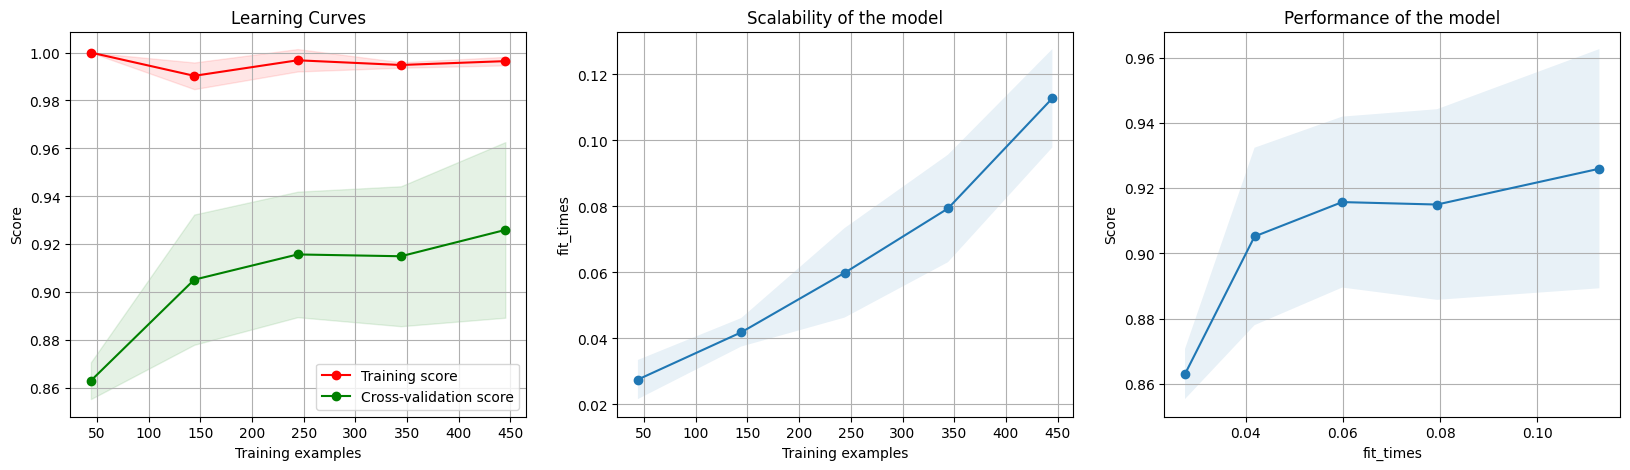

In [ ]:
# plot learning curces X_train_cleaned_sparse_embed
plot_learning_curve(best_estimator_pipeline1_round1, 'Learning Curves',
                    X_train_cleaned_sparse_embed, y_train, n_jobs=-1,scoring = 'f1_weighted')

<font color ='indianred'>**Observations**</font>
<br>
We can see that model is overfitting on the training data, we can improve results by either adding more data or reducing the model complexity of vectorizer


### <font color = 'pickle'>**Check Cross Validation Score and Train Score**

In [ ]:
# let's check the train scores or X_train_cleaned_sparse_embed
print(best_estimator_pipeline1_round1.score(
    X_train_cleaned_sparse_embed, y_train))

# let's check the cross validation score
print(complete_grid_pipeline1_round1.best_score_)

0.9964093357271095
0.9284190483757839


### <font color ='pickle'>**Evaluate model on test datset**

In [ ]:
# Final Pipeline
def final_pipeline(text):
    # cleaned_text = cp.SpacyPreprocessor(model='en_core_web_sm').transform(text)
    cleaned_text = joblib.load(file_X_test_cleaned_sparse_embed)
    best_estimator_pipeline1_round1 = joblib.load(
        file_best_estimator_pipeline1_round1)
    predictions = best_estimator_pipeline1_round1.predict(cleaned_text)
    return predictions


In [ ]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

### <font color ='pickle'>**Classification report for test dataset**

In [ ]:
print('\nTest set classification report:\n\n',
      classification_report(y_test, y_test_pred))


Test set classification report:

               precision    recall  f1-score   support

           0       0.96      0.97      0.97       480
           1       0.82      0.73      0.77        77

    accuracy                           0.94       557
   macro avg       0.89      0.85      0.87       557
weighted avg       0.94      0.94      0.94       557



## <font color ='pickle'>**Pipeline 2: Data Preprocessing + Manual Features + ML Model pipeline**

### <font color ='pickle'>**Generate Manual Features**

I will use some manual features like 'count_words','count_characters','count_characters_no_space', 'avg_word_length', 'count_digits', 'count_numbers', 'count_emails', 'count_urls', 'count_spelling_mistakes' and for generating those features we will use the ManualFeatures class,
I believe that typically in a spam message/email there is a high chance of having an url,email and high count of spelling mistakes that are made might be higher so I have created a new function spam_features in ManualFeatures class that creates the below three 'count_emails', 'count_urls', 'count_spelling_mistakes' features, for counting spelling mistakes we are using pyspellchecker

In [ ]:
ManualFeatures??

In [ ]:
featurizer = ManualFeatures(spacy_model='en_core_web_sm',spam_features = True,count_features = True ,pos_features =False, ner_features= False)

In [ ]:
X_train_features, feature_names = featurizer.fit_transform(X_train)

In [ ]:
X_train_features[0:3]

array([[ 44.        , 198.        , 155.        ,   3.44444444,
          0.        ,   0.        ,   0.        ,   2.        ,
          6.        ],
       [ 10.        ,  41.        ,  32.        ,   2.90909091,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [ 20.        ,  77.        ,  58.        ,   2.76190476,
          1.        ,   1.        ,   0.        ,   2.        ,
          7.        ]])

In [ ]:
feature_names

['count_words',
 'count_characters',
 'count_characters_no_space',
 'avg_word_length',
 'count_digits',
 'count_numbers',
 'count_emails',
 'count_urls',
 'count_spelling_mistakes']

### <font color ='pickle'>**Create Pipeline**

In [ ]:
classifier_2 = Pipeline([
    ('classifier', XGBClassifier())
])

### <font color ='pickle'>**Parameter Grid**

In [ ]:
param_grid_classifier_2 = {'classifier__scale_pos_weight': [1, 6, 7, 10,50, 100]}

### <font color ='pickle'>**Specify GridSearch**

In [ ]:
# the typical value of cv used is 5

grid_classifier_2 = HalvingGridSearchCV(estimator=classifier_2,
                                 param_grid=param_grid_classifier_2,
                                 cv=5, scoring='f1_weighted')


### <font color ='pickle'>**Fit the Model**

In [ ]:
# Fit the model on training data
grid_classifier_2.fit(X_train_features, y_train)


HalvingGridSearchCV(estimator=Pipeline(steps=[('classifier',
                                               XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=False,
                                                             eval_metric=None,
                                                             feature_types=None,
                                                             gamma=None,
                                                             gpu_id=None,
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_cons...
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             predictor=None,
                                                             random_state=None, ...))]),
                    param_grid={'classifier__scale_pos_weight': [1, 6, 7, 10,
                                                                 50, 100]},
                    scoring='f1_weighted')

### <font color ='pickle'>**Get Best Params**

In [ ]:
print(f'Best cross-validation score: {grid_classifier_2.best_score_:.2f}')
print("\nBest parameters: ", grid_classifier_2.best_params_)
print("\nBest estimator: ", grid_classifier_2.best_estimator_)


Best cross-validation score: 0.97

Best parameters:  {'classifier__scale_pos_weight': 7}

Best estimator:  Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
              

### <font color ='pickle'>**Save Model**

In [ ]:
file_best_estimator_pipeline2_round1 = model_folder / \
    'pipeline2_round1_best_estimator.pkl'
file_complete_grid_pipeline2_round1 = model_folder / \
    'pipeline2_round1_complete_grid.pkl'


In [ ]:
joblib.dump(grid_classifier_2.best_estimator_,
            file_best_estimator_pipeline2_round1)
joblib.dump(grid_classifier_2, file_complete_grid_pipeline2_round1)


### <font color ='pickle'>**Load Saved Model**

In [ ]:
# load the saved model
best_estimator_pipeline2_round1 = joblib.load(
    file_best_estimator_pipeline2_round1)
complete_grid_pipeline2_round1 = joblib.load(
    file_complete_grid_pipeline2_round1)


### <font color ='pickle'>**Plot Learning Curve**

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

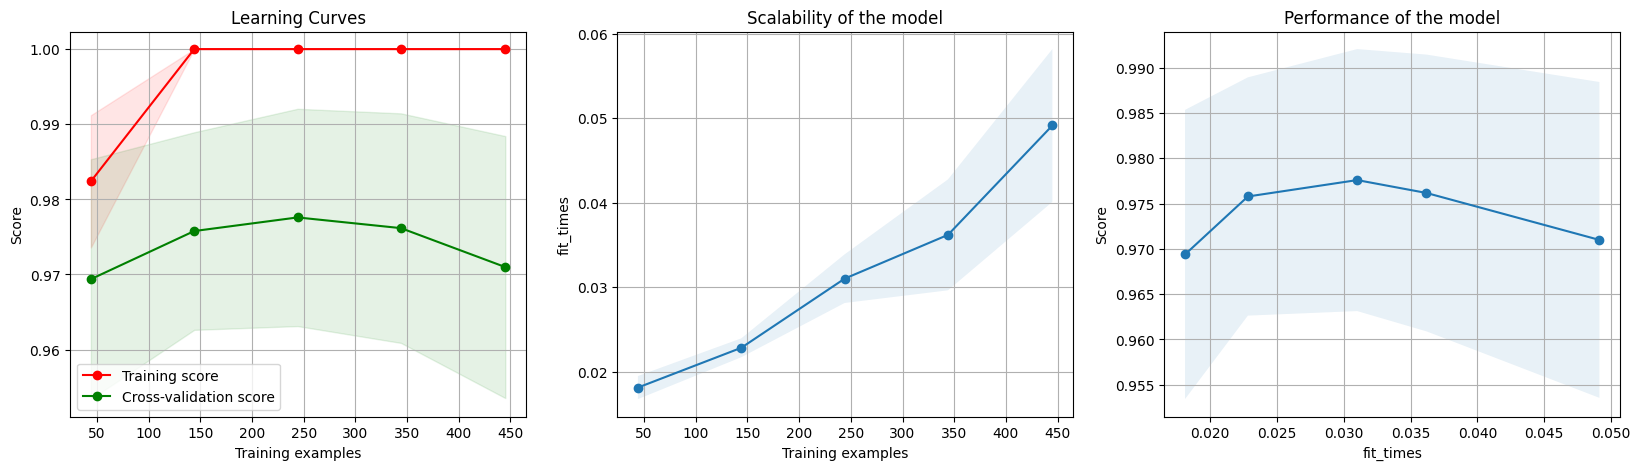

In [ ]:
# plot learning curces
plot_learning_curve(best_estimator_pipeline2_round1, 'Learning Curves',
                    X_train_features, y_train, n_jobs=-1,scoring='f1_weighted')


<font color ='indianred'>**Observations**</font>
<br>
We can see that model is overfitting on the training data, we can improve results by either adding more data or reducing the features, also we are just using count_features and spam_features we did not use ner_features or pos_features


### <font color = 'pickle'>**Check Cross Validation Score and Train Score**

In [ ]:
# let's check the train scores
print(best_estimator_pipeline2_round1.score(X_train_features, y_train))

# let's check the cross validation score
print(complete_grid_pipeline2_round1.best_score_)


1.0
0.9724905515475962


### <font color ='pickle'>**Evaluate model on test datset**

In [ ]:
# Final Pipeline
def final_pipeline(text):
    features, feature_names = featurizer.fit_transform(text)
    best_estimator_pipeline2_round1 = joblib.load(
        file_best_estimator_pipeline2_round1)
    predictions = best_estimator_pipeline2_round1.predict(features)
    return predictions


In [ ]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

### <font color ='pickle'>**Classification report for test dataset**

In [ ]:
print('\nTest set classification report:\n\n',
      classification_report(y_test, y_test_pred))



Test set classification report:

               precision    recall  f1-score   support

           0       0.98      0.99      0.98       480
           1       0.93      0.86      0.89        77

    accuracy                           0.97       557
   macro avg       0.95      0.92      0.94       557
weighted avg       0.97      0.97      0.97       557



## <font color ='pickle'>**Pipeline 3: Combine Manual Features and TfID vectors**

In this pipeline we will combine the Manual Features and TFIDF vector

In [ ]:
X_train_cleaned_sparse_embed = joblib.load(file_X_train_cleaned_sparse_embed)

In [ ]:
X_train_final = pd.concat((pd.DataFrame(X_train_cleaned_sparse_embed, columns=['cleaned_text']),
                           pd.DataFrame(X_train_features, columns=feature_names)), axis=1)

In [ ]:
X_train_final.head()

,cleaned_text,count_words,count_characters,count_characters_no_space,avg_word_length,count_digits,count_numbers,count_emails,count_urls,count_spelling_mistakes
0,u want come back?.a beautiful necklace token h...,44.0,198.0,155.0,3.444444,0.0,0.0,0.0,2.0,6.0
1,Orh tot u dun believe .,10.0,41.0,32.0,2.909091,0.0,0.0,0.0,0.0,0.0
2,sorry wo b able 2 friday.hope u find alternati...,20.0,77.0,58.0,2.761905,1.0,1.0,0.0,2.0,7.0
3,Wat u like 4 ur birthday ?,6.0,28.0,23.0,3.285714,1.0,1.0,0.0,0.0,0.0
4,O ic lol . play 9 doors yo,8.0,38.0,31.0,3.444444,1.0,1.0,0.0,0.0,0.0


In [ ]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557 entries, 0 to 556
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cleaned_text               557 non-null    object 
 1   count_words                557 non-null    float64
 2   count_characters           557 non-null    float64
 3   count_characters_no_space  557 non-null    float64
 4   avg_word_length            557 non-null    float64
 5   count_digits               557 non-null    float64
 6   count_numbers              557 non-null    float64
 7   count_emails               557 non-null    float64
 8   count_urls                 557 non-null    float64
 9   count_spelling_mistakes    557 non-null    float64
dtypes: float64(9), object(1)
memory usage: 43.6+ KB


In [ ]:
subset = X_train_final[0:10]
subset.shape

(10, 10)

In [ ]:
class SparseTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return csr_matrix(X)

In [ ]:
sparse_features = Pipeline([('sparse', SparseTransformer()), ])
vectorizer = Pipeline([('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+",max_features=5, lowercase= False))])


In [ ]:
sparse_features.fit_transform(subset.iloc[:, 1:])

<10x9 sparse matrix of type '<class 'numpy.float64'>'
	with 56 stored elements in Compressed Sparse Row format>

In [ ]:
vectorizer.fit_transform(subset.iloc[:, 0])

<10x5 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

In [ ]:
combined_features = ColumnTransformer(
    transformers=[
        ('tfidf', vectorizer, 'cleaned_text'),
    ], remainder=sparse_features
)

In [ ]:
test = combined_features.fit_transform(subset)

In [ ]:
test

array([[  0.        ,   0.70710678,   0.        ,   0.        ,
          0.70710678,  44.        , 198.        , 155.        ,
          3.44444444,   0.        ,   0.        ,   0.        ,
          2.        ,   6.        ],
       [  0.        ,   0.70710678,   0.        ,   0.        ,
          0.70710678,  10.        ,  41.        ,  32.        ,
          2.90909091,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          1.        ,  20.        ,  77.        ,  58.        ,
          2.76190476,   1.        ,   1.        ,   0.        ,
          2.        ,   7.        ],
       [  0.        ,   0.        ,   0.81979472,   0.        ,
          0.5726575 ,   6.        ,  28.        ,  23.        ,
          3.28571429,   1.        ,   1.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   1.        ,   0.        ,   0.        ,
          0.        

In [ ]:
test.dtype

dtype('float64')

### <font color ='pickle'>**Create Final Pipeline**

In [ ]:
classifier_3 = Pipeline([('combined_features',  combined_features),
                         ('classifier', XGBClassifier()),
                         ])


In [ ]:
classifier_3.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'combined_features', 'classifier', 'combined_features__n_jobs', 'combined_features__remainder__memory', 'combined_features__remainder__steps', 'combined_features__remainder__verbose', 'combined_features__remainder__sparse', 'combined_features__remainder', 'combined_features__sparse_threshold', 'combined_features__transformer_weights', 'combined_features__transformers', 'combined_features__verbose', 'combined_features__verbose_feature_names_out', 'combined_features__tfidf', 'combined_features__tfidf__memory', 'combined_features__tfidf__steps', 'combined_features__tfidf__verbose', 'combined_features__tfidf__tfidf', 'combined_features__tfidf__tfidf__analyzer', 'combined_features__tfidf__tfidf__binary', 'combined_features__tfidf__tfidf__decode_error', 'combined_features__tfidf__tfidf__dtype', 'combined_features__tfidf__tfidf__encoding', 'combined_features__tfidf__tfidf__input', 'combined_features__tfidf__tfidf__lowercase', 'combined_features__tfidf_

### <font color ='pickle'>**Parameter Grid**

In [ ]:
param_grid_classifier_3 = {'combined_features__tfidf__tfidf__max_features': [1000, 2000, 5000],
                           'combined_features__tfidf__tfidf__min_df' : [1, 2, 3],
                           'combined_features__tfidf__tfidf__max_df' : [5, 10, 15],
                           'combined_features__tfidf__tfidf__ngram_range' : [(1, 1), (1, 2), (1, 3)],
                           'classifier__scale_pos_weight': [1, 6, 7, 10,50, 100]
                           }

### <font color ='pickle'>**Specify GridSearch**

In [ ]:
grid_classifier_3 = HalvingGridSearchCV(estimator=classifier_3,
                                 param_grid=param_grid_classifier_3,
                                 cv=5,scoring = 'f1_weighted')

### <font color ='pickle'>**Fit the Model**

In [ ]:
# Fit the model on training data
grid_classifier_3.fit(X_train_final, y_train)

HalvingGridSearchCV(estimator=Pipeline(steps=[('combined_features',
                                               ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                                                            SparseTransformer())]),
                                                                 transformers=[('tfidf',
                                                                                Pipeline(steps=[('tfidf',
                                                                                                 TfidfVectorizer(lowercase=False,
                                                                                                                 max_features=5,
                                                                                                                 token_pattern='[\\S]+'))]),
                                                                                'cleaned_text')])),
                                              ('classifier',
                                               XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callback...
                                                             predictor=None,
                                                             random_state=None, ...))]),
                    param_grid={'classifier__scale_pos_weight': [1, 6, 7, 10,
                                                                 50, 100],
                                'combined_features__tfidf__tfidf__max_df': [5,
                                                                            10,
                                                                            15],
                                'combined_features__tfidf__tfidf__max_features': [1000,
                                                                                  2000,
                                                                                  5000],
                                'combined_features__tfidf__tfidf__min_df': [1,
                                                                            2,
                                                                            3],
                                'combined_features__tfidf__tfidf__ngram_range': [(1,
                                                                                  1),
                                                                                 (1,
                                                                                  2),
                                                                                 (1,
                                                                                  3)]},
                    scoring='f1_weighted')

### <font color ='pickle'>**Get Best Params**

In [ ]:
print(
    "Best cross-validation score: {:.2f}".format(grid_classifier_3.best_score_))
print("\nBest parameters: ", grid_classifier_3.best_params_)
print("\nBest estimator: ", grid_classifier_3.best_estimator_)

Best cross-validation score: 0.98

Best parameters:  {'classifier__scale_pos_weight': 6, 'combined_features__tfidf__tfidf__max_df': 15, 'combined_features__tfidf__tfidf__max_features': 1000, 'combined_features__tfidf__tfidf__min_df': 2, 'combined_features__tfidf__tfidf__ngram_range': (1, 1)}

Best estimator:  Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(lowercase=False,
                                                                                   max_df=15,
                                                                                   max_features=1000,
                                                              

### <font color ='pickle'>**Save Model**

In [ ]:
file_best_estimator_pipeline3_round1 = model_folder / \
    'pipeline3_round1_best_estimator.pkl'
file_complete_grid_pipeline3_round1 = model_folder / \
    'pipeline3_round1_complete_grid.pkl'

In [ ]:
joblib.dump(grid_classifier_3.best_estimator_,
            file_best_estimator_pipeline3_round1)
joblib.dump(grid_classifier_3, file_complete_grid_pipeline3_round1)

### <font color ='pickle'>**Load Saved Model**

In [ ]:
# load the saved model
best_estimator_pipeline3_round1 = joblib.load(
    file_best_estimator_pipeline3_round1)
complete_grid_pipeline3_round1 = joblib.load(
    file_complete_grid_pipeline3_round1)

### <font color ='pickle'>**Plot Learning Curve**

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

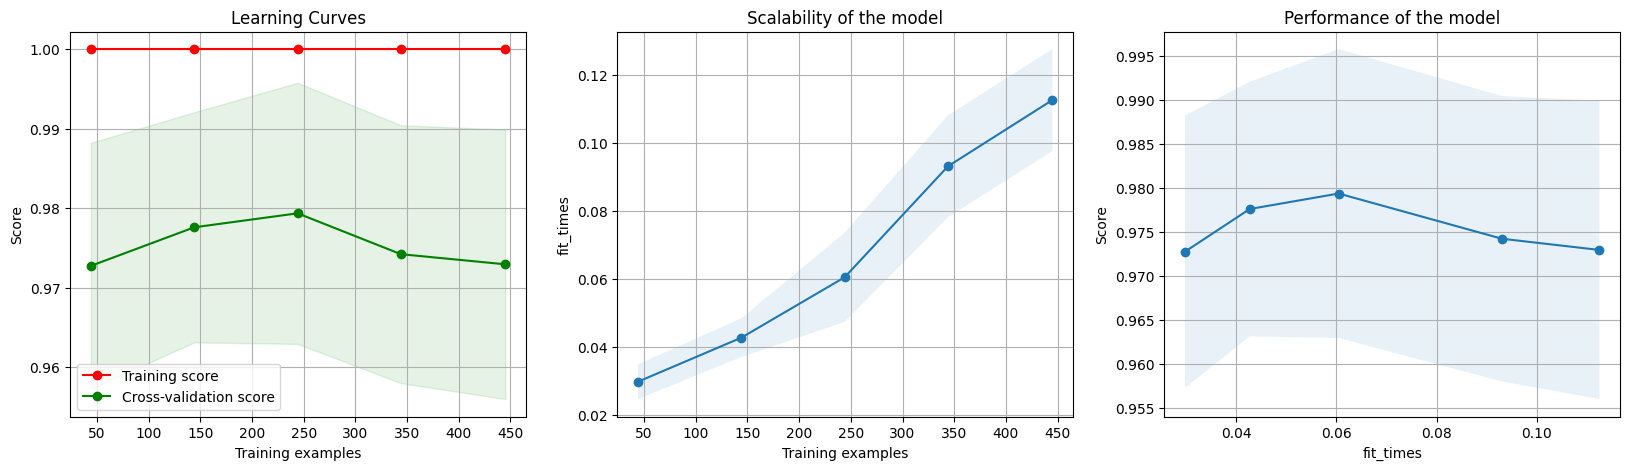

In [ ]:
# plot learning curces
plot_learning_curve(best_estimator_pipeline3_round1, 'Learning Curves',
                    X_train_final, y_train, n_jobs=-1,scoring = 'f1_weighted')

<font color ='indianred'>**Observations**</font>
<br>
We can see that model is overfitting on the training data, we can improve results by either adding more data or reducing the features or decreasing the model complexity


### <font color = 'pickle'>**Check Cross Validation Score and Train Score**

In [ ]:
# let's check the train scores
print(best_estimator_pipeline3_round1.score(X_train_final, y_train))

# let's check the cross validation score
print(complete_grid_pipeline3_round1.best_score_)

1.0
0.9754980331030261


### <font color ='pickle'>**Evaluate model on test datset**

In [ ]:
X_test.shape

(557,)

In [ ]:
# Final Pipeline
def final_pipeline(text):
    cleaned_text = cp.SpacyPreprocessor(model='en_core_web_sm').transform(text)
    # cleaned_text = joblib.load(file_X_test_cleaned_sparse_embed)
    X_features, feature_names = featurizer.fit_transform(text)
    X_final = pd.concat((pd.DataFrame(cleaned_text, columns=['cleaned_text']),
                         pd.DataFrame(X_features, columns=feature_names)), axis=1)
    best_estimator_pipeline3_round1 = joblib.load(
        file_best_estimator_pipeline3_round1)
    predictions = best_estimator_pipeline3_round1.predict(X_final)
    return predictions

In [ ]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

### <font color ='pickle'>**Classification report for test dataset**

In [ ]:
print('\nTest set classification report:\n\n',
      classification_report(y_test, y_test_pred))


Test set classification report:

               precision    recall  f1-score   support

           0       0.98      0.99      0.99       480
           1       0.94      0.87      0.91        77

    accuracy                           0.97       557
   macro avg       0.96      0.93      0.95       557
weighted avg       0.97      0.97      0.97       557

